In [ ]:
#pip install pysurvival

     |████████████████████████████████| 4.7 MB 9.1 MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp37-cp37m-linux_x86_64.whl size=3773257 sha256=105b68b9908c46e4f967e7f549d45cf61c06c472babd3f76236179521cd814e4
  Stored in directory: /root/.cache/pip/wheels/1a/63/e2/32273d765a4e2f4ccac69c8adf97425ca80bab5d0c8447f120
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=21a6fd9d65bcb51b5e69c8fb6e39fe72669972218e4c79324dcd8d83647b2756
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built pysurvival progressbar


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

# Reading the dataset
raw_dataset = Dataset('maintenance').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(5)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (1000, 7).


,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [ ]:
# Defining the time and event column
time_column = 'lifetime'
event_column = 'broken'

# Encoding the categorical variables as one-hot vectors
categories = ['provider', 'team']
dataset = pd.get_dummies(raw_dataset, columns = categories, drop_first=True)

# Defining the modeling features
features = np.setdiff1d(dataset.columns, ['lifetime', 'broken']).tolist()

In [ ]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The dataset contains 0 null values
The dataset contains 0 duplicates


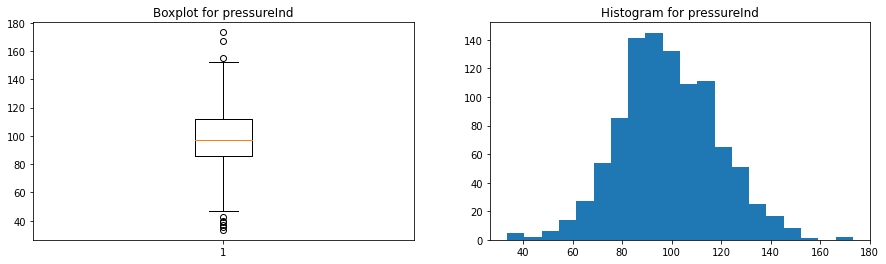

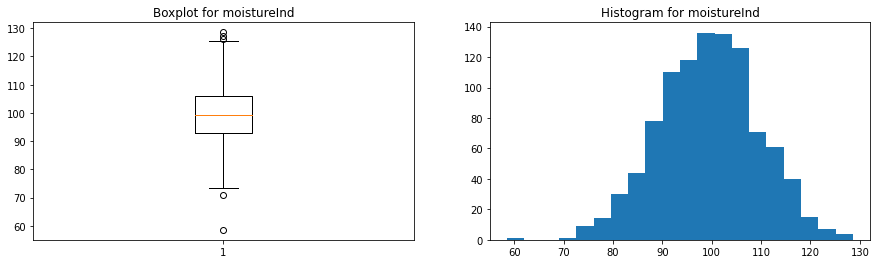

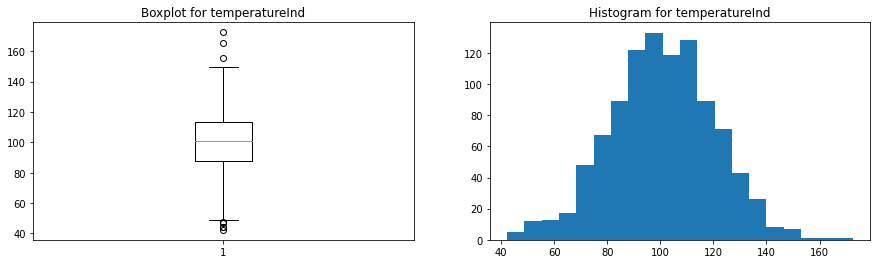

In [ ]:
for feature in ['pressureInd','moistureInd','temperatureInd']:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )

    # Display
    plt.show()

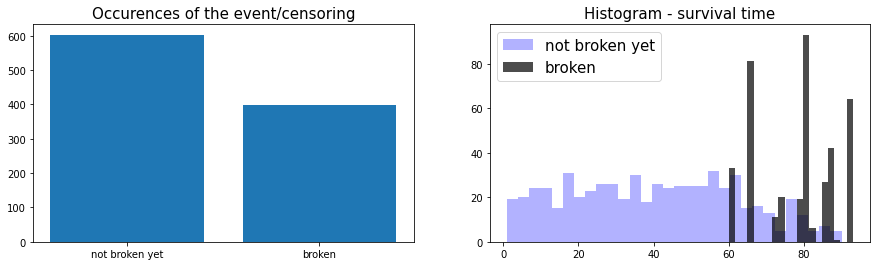

In [ ]:
from collections import Counter
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['broken'].replace({0:'not broken yet', 1:'broken'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[ raw_dataset['broken'] == 0, 'lifetime']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'not broken yet')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset['broken'] == 1, 'lifetime']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'broken')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

In [ ]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.4)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [ ]:
from pysurvival.models.multi_task import LinearMultiTaskModel

# Initializing the MTLR with a time axis split into 300 intervals
linear_mtlr = LinearMultiTaskModel(bins=300)

# Fitting the model
linear_mtlr.fit(X_train, T_train, E_train, num_epochs = 1000,
                init_method = 'orthogonal', optimizer ='rmsprop',
                lr = 1e-3, l2_reg = 3,  l2_smooth = 3, )

LinearMultiTaskModel

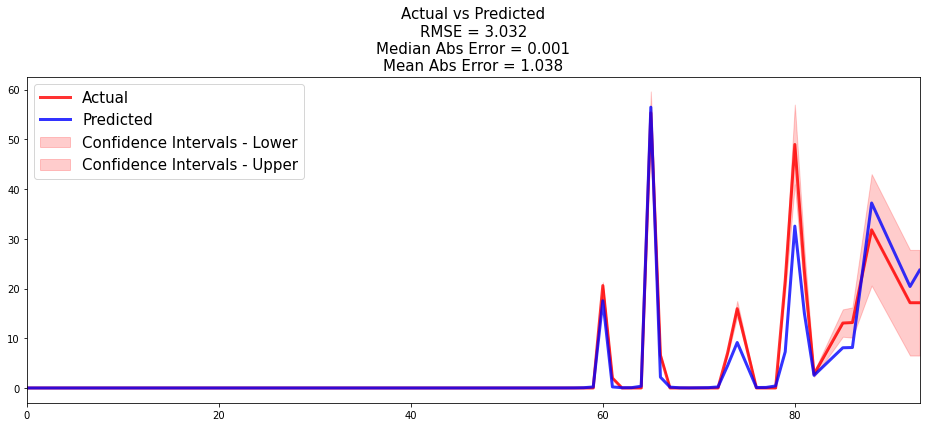

In [ ]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(linear_mtlr, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

ValueError: ignored

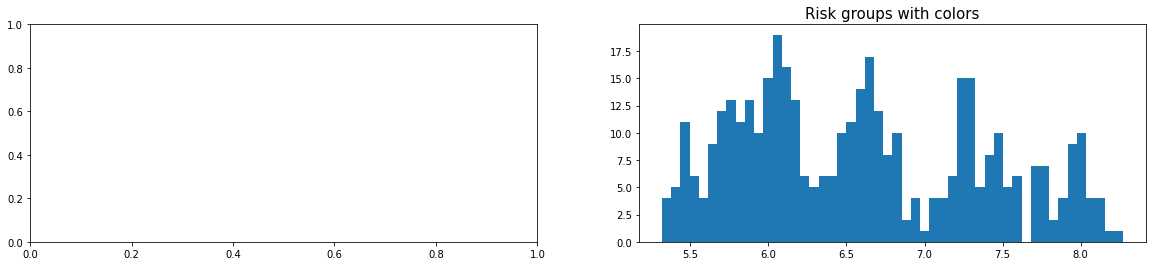

In [ ]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=linear_mtlr, X=X_test,
    use_log = True, num_bins=50, figure_size=(20, 4),
    low= {'lower_bound':0, 'upper_bound':1.8, 'color':'red'},
    medium= {'lower_bound': 1.8, 'upper_bound':1.93, 'color':'green'},
    high= {'lower_bound':1.93, 'upper_bound':2.1, 'color':'blue'}
    )